In [40]:
import os, shutil, warnings, torch
import pandas as pd

import torch.nn as nn
import torch.optim as optim
from torchmetrics import Accuracy, F1Score
from torch.utils.data import DataLoader, TensorDataset

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from transformers import AutoModelForSequenceClassification, AutoTokenizer, get_linear_schedule_with_warmup

In [41]:
sns.set_theme(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

warnings.filterwarnings("ignore")

ds_folder = r'C:\Users\parvs\VSC Codes\Python-root\_Projects_Personal\mindEase_v2\datasets\Conversational Training\Intent Based\difDs'

trainfile = os.path.join(ds_folder, 'train.csv')
validfile = os.path.join(ds_folder, 'val.csv')
testfile = os.path.join(ds_folder, 'test.csv')

traindf = pd.read_csv(trainfile)
validdf = pd.read_csv(validfile)
testdf = pd.read_csv(testfile)

In [42]:
model_name = "distilbert/distilbert-base-uncased" 
tokenizer = AutoTokenizer.from_pretrained(model_name)

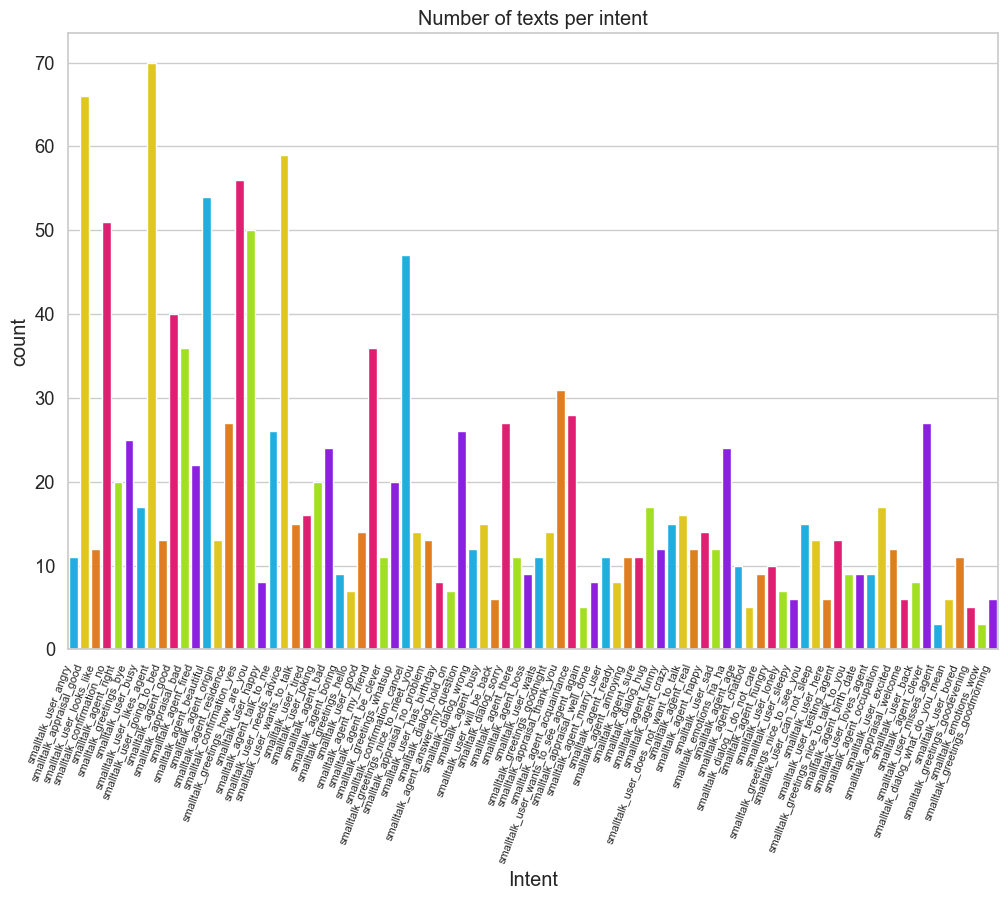

In [43]:
trainfeatures = traindf.copy()
trainlabels = trainfeatures.pop("Intent")

testfeatures = testdf.copy()
testlabels = testfeatures.pop("Intent")

validfeatures = validdf.copy()
validlabels = validfeatures.pop("Intent")

chart = sns.countplot(x=trainlabels, palette=HAPPY_COLORS_PALETTE)
plt.title("Number of texts per intent")
chart.set_xticklabels(chart.get_xticklabels(), rotation=69, horizontalalignment='right', fontsize=8)

# Get the x-axis entries
x_axis_entries = [tick.get_text() for tick in chart.get_xticklabels()]
len_dims = len(x_axis_entries)

In [44]:
label_encoder = LabelEncoder()

trainlabels = label_encoder.fit_transform(trainlabels.values)
testlabels = label_encoder.transform(testlabels.values)
validlabels = label_encoder.transform(validlabels.values)

In [45]:
class IntentClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super(IntentClassifier, self).__init__()
        self.bert = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
        self.dropout = nn.Dropout(0.1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        return outputs.logits

num_labels = len_dims
model = IntentClassifier(model_name, num_labels).to('cuda')

def prepare_data(features, labels):
    features = [str(feature) for feature in features]
    features = tokenizer(features, padding=True, truncation=True, return_tensors="pt")
    
    labels = torch.tensor(labels).long().to('cuda')  # Change to long tensor
    
    dataset = TensorDataset(features['input_ids'], features['attention_mask'], labels)
    return dataset

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [108]:
epochs = 15

# Prepare train, validation, and test datasets
train_dataset = prepare_data(trainfeatures.values, trainlabels)
valid_dataset = prepare_data(validfeatures.values, validlabels)
test_dataset = prepare_data(testfeatures.values, testlabels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# loss_fn = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss for multi-label classification
loss_fn = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=2e-5)
optimizer = optim.Adam(model.parameters(), lr=1e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * epochs)

# accuracy = Accuracy(task='binary').to('cuda') 
# accuracy = Accuracy(task='multiclass', num_classes=num_labels, average='micro').to('cuda') 
accuracy = Accuracy(task='multiclass', num_classes=num_labels).to('cuda') 
f1_score = F1Score(task='multiclass', num_classes=num_labels, average='macro').to('cuda')

In [81]:
model.cuda()

train_losses = []
train_accuracies = []
train_f1_scores = []
val_losses = []
val_accuracies = []
val_f1_scores = []

for epoch in range(epochs):

    model.train()
    total_loss = 0
    total_accuracy = 0
    total_f1 = 0 

    for batch in train_loader:

        input_ids, attention_mask, labels = [x.to('cuda') for x in batch] 

        
        optimizer.zero_grad()
        logits = model(input_ids, attention_mask=attention_mask)
        loss = loss_fn(logits, labels)

        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

        total_accuracy += accuracy(logits, labels)
        total_f1 += f1_score(logits, labels)

    avg_loss = total_loss / len(train_loader)
    avg_accuracy = total_accuracy / len(train_loader)
    avg_f1 = total_f1 / len(train_loader)

    train_losses.append(avg_loss)
    train_accuracies.append(avg_accuracy)
    train_f1_scores.append(avg_f1)

    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Training loss: {avg_loss:.4f}, Training accuracy: {avg_accuracy:.4f}, Training F1: {avg_f1:.4f}")

    model.eval()
    total_val_loss = 0
    total_val_accuracy = 0
    total_val_f1 = 0

    with torch.no_grad():
        for batch in valid_loader:
            input_ids, attention_mask, labels = [x.to('cuda') for x in batch]

            logits = model(input_ids, attention_mask=attention_mask)

            val_loss = loss_fn(logits, labels)
            total_val_loss += val_loss.item()
            total_val_accuracy += accuracy(logits, labels)
            total_val_f1 += f1_score(logits, labels)

    avg_val_loss = total_val_loss / len(valid_loader)
    avg_val_accuracy = total_val_accuracy / len(valid_loader)
    avg_val_f1 = total_val_f1 / len(valid_loader)

    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_accuracy)
    val_f1_scores.append(avg_val_f1)

    print(f"Validation loss: {avg_val_loss:.4f}, Validation accuracy: {avg_val_accuracy:.4f}, Validation F1: {avg_val_f1:.4f}")

Epoch 1/15
Training loss: 0.1605, Training accuracy: 0.9913, Training F1: 0.9832
Validation loss: 0.3659, Validation accuracy: 0.9406, Validation F1: 0.9047
Epoch 2/15
Training loss: 0.1367, Training accuracy: 0.9928, Training F1: 0.9864
Validation loss: 0.3526, Validation accuracy: 0.9386, Validation F1: 0.9022
Epoch 3/15
Training loss: 0.1292, Training accuracy: 0.9922, Training F1: 0.9836
Validation loss: 0.3402, Validation accuracy: 0.9406, Validation F1: 0.9064
Epoch 4/15
Training loss: 0.1170, Training accuracy: 0.9935, Training F1: 0.9876
Validation loss: 0.3263, Validation accuracy: 0.9406, Validation F1: 0.9060
Epoch 5/15
Training loss: 0.1065, Training accuracy: 0.9948, Training F1: 0.9898
Validation loss: 0.3233, Validation accuracy: 0.9426, Validation F1: 0.9066
Epoch 6/15
Training loss: 0.1014, Training accuracy: 0.9935, Training F1: 0.9873
Validation loss: 0.3148, Validation accuracy: 0.9386, Validation F1: 0.9008
Epoch 7/15
Training loss: 0.0936, Training accuracy: 0.996

In [106]:
import torch

saved_model_name = f"savedModel_{epochs}_{avg_val_accuracy:.4f}.pth"

torch.save(model.state_dict(), saved_model_name)

print(f"Validation loss: {avg_val_loss:.4f}, Validation accuracy: {avg_val_accuracy:.4f}, Validation F1: {avg_val_f1:.4f}")
print(f"Model saved to {saved_model_name}")

Validation loss: 0.2989, Validation accuracy: 0.9426, Validation F1: 0.9080
Model saved to savedModel_15_0.9426.pth


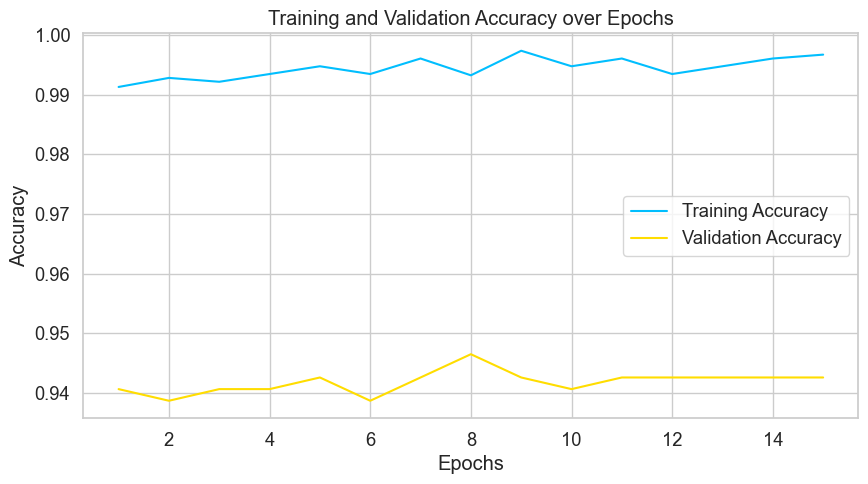

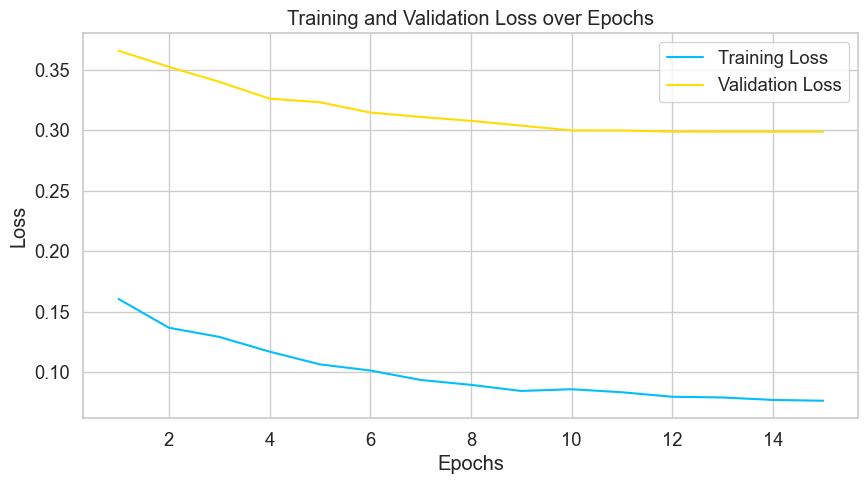

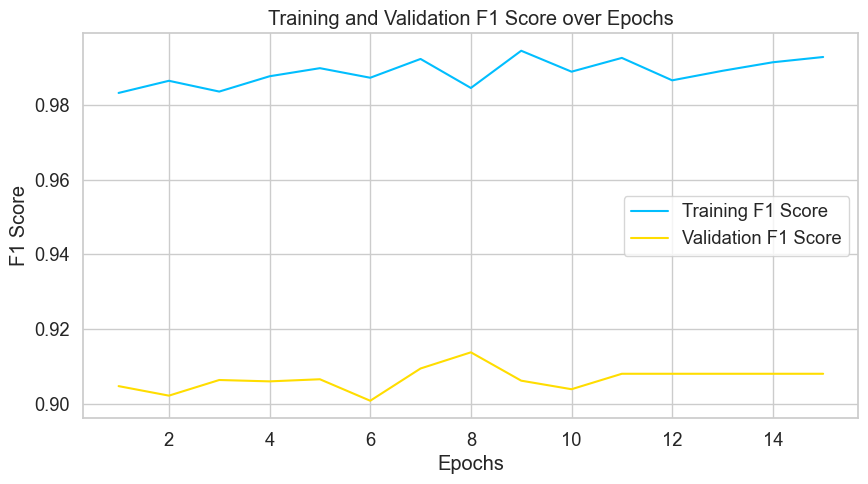

Plots have been saved as 'accuracy_plot.png', 'loss_plot.png', and 'f1_score_plot.png'


In [97]:
import matplotlib.pyplot as plt
import numpy as np

# Convert tensors to numpy arrays
train_accuracies_np = [acc.cpu().numpy() for acc in train_accuracies]
val_accuracies_np = [acc.cpu().numpy() for acc in val_accuracies]
train_losses_np = train_losses  # These should already be float values
val_losses_np = val_losses  # These should already be float values
train_f1_scores_np = [f1.cpu().numpy() for f1 in train_f1_scores]
val_f1_scores_np = [f1.cpu().numpy() for f1 in val_f1_scores]

# Plotting Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_accuracies_np, label='Training Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies_np, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.savefig('accuracy_plot.png')
# plt.close()
plt.show()

# Plotting Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses_np, label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses_np, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.savefig('loss_plot.png')
# plt.close()
plt.show()

# Plotting F1 Score
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_f1_scores_np, label='Training F1 Score')
plt.plot(range(1, epochs + 1), val_f1_scores_np, label='Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Training and Validation F1 Score over Epochs')
plt.legend()
plt.grid(True)
plt.savefig('f1_score_plot.png')
# plt.close()
plt.show()

print("Plots have been saved as 'accuracy_plot.png', 'loss_plot.png', and 'f1_score_plot.png'")

In [98]:
# Testing the Model
model.eval()
total_test_loss = 0
total_test_accuracy = 0
total_test_f1 = 0

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [x.to('cuda') for x in batch]

        logits = model(input_ids, attention_mask=attention_mask)

        test_loss = loss_fn(logits, labels)
        total_test_loss += test_loss.item()
        total_test_accuracy += accuracy(logits, labels)
        total_test_f1 += f1_score(logits, labels)

avg_test_loss = total_test_loss / len(test_loader)
avg_test_accuracy = total_test_accuracy / len(test_loader)
avg_test_f1 = total_test_f1 / len(test_loader)

print(f"Test loss: {avg_test_loss:.4f}, Test accuracy: {avg_test_accuracy:.4f}, Test F1: {avg_test_f1:.4f}")

Test loss: 0.4110, Test accuracy: 0.9156, Test F1: 0.8393


In [105]:
def predict_intent(text, model, tokenizer, label_encoder, device):
    # Prepare the input
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt")
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    # Set the model to evaluation mode
    model.eval()

    # Perform inference
    with torch.no_grad():
        logits = model(input_ids, attention_mask=attention_mask)

    # Get the predicted class
    predicted_class = torch.argmax(logits, dim=1).item()

    # Convert the predicted class back to the original label
    predicted_intent = label_encoder.inverse_transform([predicted_class])[0]

    return predicted_intent

# Load the saved model
model = IntentClassifier(model_name, num_labels)
model.load_state_dict(torch.load(saved_model_name))
model.to(device)

# Example usage
text = "How should I deal with depression ?"
predicted_intent = predict_intent(text, model, tokenizer, label_encoder, device)
print(f"The predicted intent for '{text}' is: {predicted_intent}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The predicted intent for 'How should I deal with depression ?' is: smalltalk_user_sad
